In [1]:
# Import packages
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv
import os
import zipfile
from tensorflow.keras import layers, models
import matplotlib.image as mpimg
import random
from PIL import Image
import math

print("All packages imported successfully.")

All packages imported successfully.


In [2]:
print(tf.config.list_physical_devices('GPU'))  # This should show GPU details

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# Load valid metadata
metadata_path = "sample_data/metadata.csv"
valid_entries = {}

with open(metadata_path, 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        if len(row) == 5:
            try:
                coords = list(map(float, row[1:5]))
                if sum(coords) != 0:
                    valid_entries[row[0]] = coords
            except:
                pass

print(f"Found {len(valid_entries)} images with valid horizon line labels.")

Found 19809 images with valid horizon line labels.


In [4]:
# Filter train.txt to only include valid entries
train_txt_path = "sample_data/split/train.txt"
filtered_txt_path = "sample_data/split/train_valid.txt"

with open(train_txt_path, 'r') as fin, open(filtered_txt_path, 'w') as fout:
    for line in fin:
        key = line.strip().split()[0]
        if key in valid_entries:
            fout.write(key + '\n')

print("Filtered train.txt written to train_valid.txt")

Filtered train.txt written to train_valid.txt


In [5]:
image_root = "sample_data/images"
train_file = "sample_data/split/train_valid.txt"

# Load filenames
with open(train_file, 'r') as f:
    filenames = [line.strip() for line in f.readlines()]

def file_exists(fname):
    return os.path.exists(f"{image_root}/{fname}")

# Check file is a valid image
def is_valid_image(path):
    try:
        with Image.open(f"{image_root}/{path}") as img:
            img.verify()
        return True
    except:
        return False

# Final filtering
filenames = [f for f in filenames if file_exists(f) and is_valid_image(f)]
print(f"Filtered to {len(filenames)} valid, uncorrupted images.")

# Preprocessing functions
def load_and_preprocess_image(path):
    image = tf.io.read_file(tf.strings.join([image_root, "/", path]))
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    return image

def process_path(path):
    image = load_and_preprocess_image(path)
    image = tf.image.resize(image, [224, 224])

    def get_scaled_label(filename):
        key = filename.numpy().decode()
        x1, y1, x2, y2 = valid_entries[key]
        return np.array([
            (x1 + 5000) * (224 / 10000),
            (y1 + 5000) * (224 / 10000),
            (x2 + 5000) * (224 / 10000),
            (y2 + 5000) * (224 / 10000)
        ], dtype=np.float32)

    label = tf.py_function(get_scaled_label, [path], tf.float32)
    label.set_shape([4])
    return image, label

def get_label(filename):
    key = filename.numpy().decode()
    return tf.constant(valid_entries[key], dtype=tf.float32)

# Build dataset
dataset = tf.data.Dataset.from_tensor_slices(filenames)
dataset = dataset.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)

print("Dataset built successfully.")

Filtered to 16906 valid, uncorrupted images.
Dataset built successfully.


In [6]:
# Build model
model = models.Sequential([
    layers.InputLayer(input_shape=(224, 224, 3)),
    layers.Conv2D(32, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=2),
    
    layers.Conv2D(64, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=2),
    
    layers.Conv2D(128, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=2),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(4)  # Predicts x1, y1, x2, y2
])

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 128)      0

In [7]:
# Filter filenames to only those that exist
valid_files = [f for f in filenames if os.path.exists(f"{image_root}/{f}")]
print(f"Filtered to {len(valid_files)} images that actually exist.")

# Then rebuild the dataset
dataset = tf.data.Dataset.from_tensor_slices(valid_files)
dataset = dataset.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)

# # Train model
# history = model.fit(dataset, epochs=10)

# # Plot
# plt.plot(history.history['loss'])
# plt.xlabel("Epoch")
# plt.ylabel("Loss (MSE)")
# plt.title("Training Loss Over Time")
# plt.grid(True)
# plt.show()

Filtered to 16906 images that actually exist.


In [8]:
# Find min and max y
all_y = []

for coords in valid_entries.values():
    _, y1, _, y2 = coords
    all_y.extend([y1, y2])

min_y = min(all_y)
max_y = max(all_y)
print(min_y, max_y)

-13004.326846 5000.0


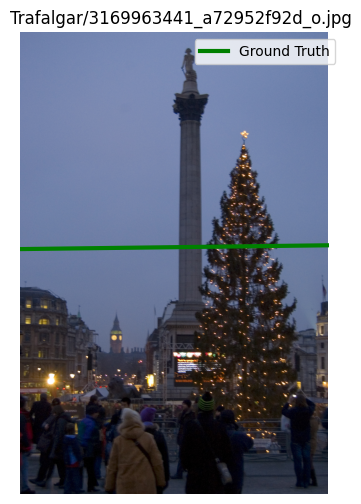

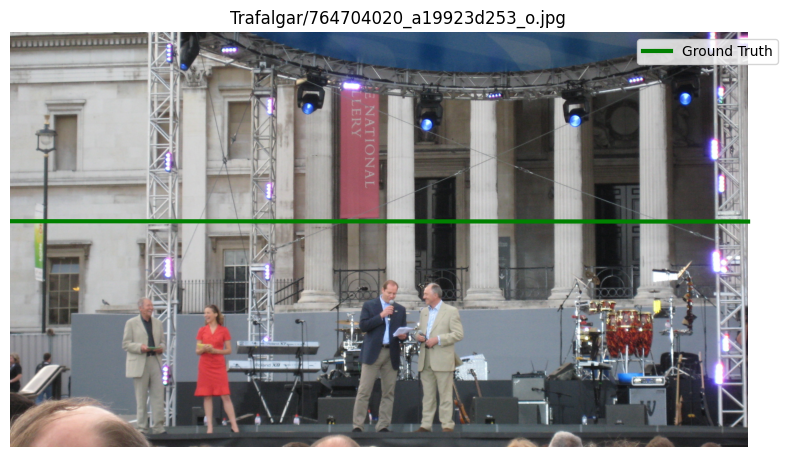

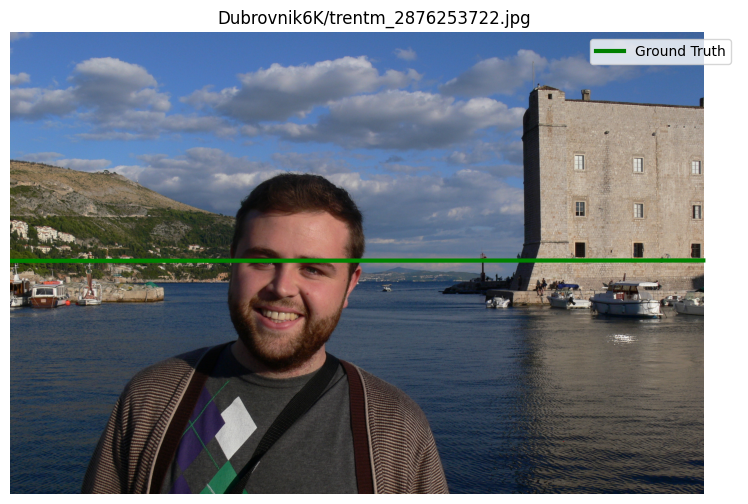

In [9]:
def plot_with_horizon(filename):
    # Load GT line (x in [-5000, 5000], y in [-5000, 5000])
    x1, y1, x2, y2 = valid_entries[filename]

    # Load image
    img_path = f"{image_root}/{filename}"
    img_raw = mpimg.imread(img_path)
    h, w = img_raw.shape[:2]

    # Scale from [-5000, 5000] → [0, w] and [0, h]
    x1_img = (x1 + 5000) * (w / 10000)
    x2_img = (x2 + 5000) * (w / 10000)
    y1_img = (y1 + 5000) * (h / 10000)
    y2_img = (y2 + 5000) * (h / 10000)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.imshow(img_raw)
    plt.plot([x1_img, x2_img], [y1_img, y2_img], 'g-', linewidth=3, label='Ground Truth')
    plt.title(filename)
    plt.axis('off')
    plt.legend()
    plt.show()

# Show a few examples
for _ in range(3):
    sample = random.choice(valid_files)
    plot_with_horizon(sample)

In [11]:
image_root = "sample_data/images"
train_valid_path = "sample_data/split/train_valid.txt"

# Rebuild train_valid.txt from all image folders
all_images = []
for subdir in os.listdir(image_root):
    folder_path = f"{image_root}/{subdir}"
    if os.path.isdir(folder_path):
        for fname in os.listdir(folder_path):
            if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                all_images.append(f"{subdir}/{fname}")

random.seed(42)
random.shuffle(all_images)

# Write to train_valid.txt
os.makedirs(os.path.dirname(train_valid_path), exist_ok=True)
with open(train_valid_path, 'w') as f:
    for path in all_images:
        f.write(f"{path}\n")
print(f"Rebuilt {train_valid_path} with {len(all_images)} entries.")

# Filter out missing files
def file_exists(fname):
    return os.path.exists(f"{image_root}/{fname}")

with open(train_valid_path, 'r') as f:
    all_filenames = [line.strip().split()[0] for line in f]

all_filenames = [f for f in all_filenames if file_exists(f)]
print(f"Found {len(all_filenames)} valid image paths.")

# Train/test split
split_idx = int(0.8 * len(all_filenames))
X_train = all_filenames[:split_idx]
X_val = all_filenames[split_idx:]

# Define dataset
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

train_ds = tf.data.Dataset.from_tensor_slices(X_train)
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.shuffle(1000).batch(BATCH_SIZE).prefetch(AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices(X_val)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

# Train model
model.compile(optimizer='adam', loss='mse')
history = model.fit(train_ds, validation_data=val_ds, epochs=10)

Rebuilt sample_data/split/train_valid.txt with 19809 entries.
Found 19809 valid image paths.
Epoch 1/10
496/496 [==============================] - 735s 1s/step - loss: 341.6117 - val_loss: 140.0740
Epoch 2/10
496/496 [==============================] - 713s 1s/step - loss: 130.7879 - val_loss: 135.2104
Epoch 3/10
496/496 [==============================] - 711s 1s/step - loss: 125.0325 - val_loss: 116.5712
Epoch 4/10
496/496 [==============================] - 708s 1s/step - loss: 118.5515 - val_loss: 116.7669
Epoch 5/10
496/496 [==============================] - 707s 1s/step - loss: 113.5096 - val_loss: 113.3083
Epoch 6/10
496/496 [==============================] - 709s 1s/step - loss: 102.7817 - val_loss: 109.5450
Epoch 8/10
496/496 [==============================] - 708s 1s/step - loss: 95.5879 - val_loss: 111.1418
Epoch 9/10
496/496 [==============================] - 704s 1s/step - loss: 89.3060 - val_loss: 102.0850
Epoch 10/10
496/496 [==============================] - 707s 1s/step -

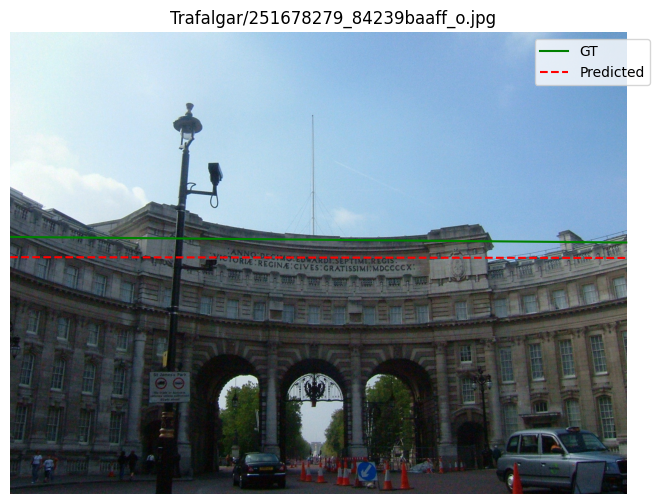

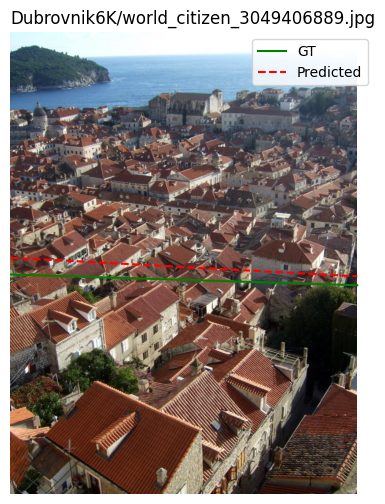

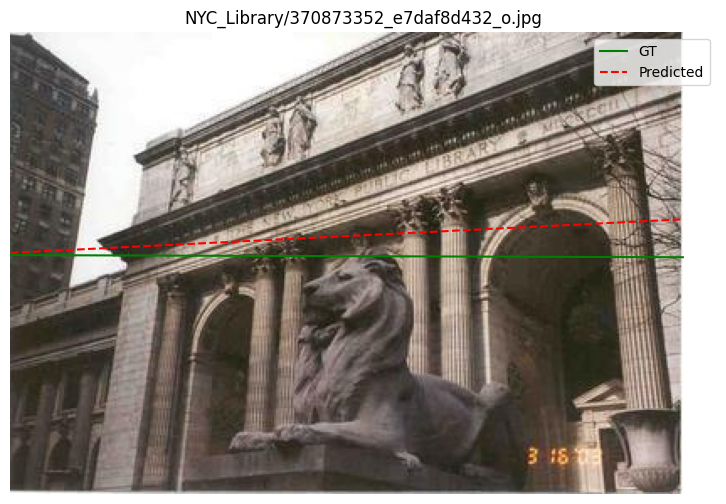

In [12]:
def unscale_prediction(pred):
    return [(x / 224) * 10000 - 5000 for x in pred]

def extend_line_to_full_width(pred):
    x1, y1, x2, y2 = pred

    if x2 == x1:
        # vertical line edge case
        return [-5000, y1, 5000, y2]

    m = (y2 - y1) / (x2 - x1)
    y_left = y1 + m * (-5000 - x1)
    y_right = y1 + m * (5000 - x1)

    return [-5000, y_left, 5000, y_right]

def visualize_prediction(filename):
    # Load image
    img_path = f"{image_root}/{filename}"
    img_raw = mpimg.imread(img_path)
    h, w = img_raw.shape[:2]

    # Load GT
    gt = valid_entries[filename]
    gt_scaled = [
        (gt[0] + 5000) * (w / 10000),
        (gt[1] + 5000) * (h / 10000),
        (gt[2] + 5000) * (w / 10000),
        (gt[3] + 5000) * (h / 10000),
    ]

    # Predict
    inp = load_and_preprocess_image(filename)
    inp = tf.image.resize(inp, [224, 224])
    pred = model.predict(tf.expand_dims(inp, axis=0), verbose=0)[0]
    pred = unscale_prediction(pred)
    
    # 🔧 Extend predicted line to edges
    pred = extend_line_to_full_width(pred)
    
    # Rescale to image coordinates
    pred_scaled = [
        (pred[0] + 5000) * (w / 10000),
        (pred[1] + 5000) * (h / 10000),
        (pred[2] + 5000) * (w / 10000),
        (pred[3] + 5000) * (h / 10000),
    ]

    # Plot
    plt.figure(figsize=(10, 6))
    plt.imshow(img_raw)
    plt.plot([gt_scaled[0], gt_scaled[2]], [gt_scaled[1], gt_scaled[3]], 'g-', label='GT')
    plt.plot([pred_scaled[0], pred_scaled[2]], [pred_scaled[1], pred_scaled[3]], 'r--', label='Predicted')
    plt.title(filename)
    plt.axis('off')
    plt.legend()
    plt.show()

# Try on a few from val set
for fname in random.sample(X_val, 3):
    visualize_prediction(fname)

In [13]:
def angle_from_coords(x1, y1, x2, y2):
    """Returns angle of line in degrees relative to horizontal axis."""
    return math.degrees(math.atan2(y2 - y1, x2 - x1))

def angular_error(gt_coords, pred_coords):
    """Computes absolute angular difference between two lines in degrees."""
    x1_gt, y1_gt, x2_gt, y2_gt = gt_coords
    x1_pred, y1_pred, x2_pred, y2_pred = pred_coords
    angle_gt = angle_from_coords(x1_gt, y1_gt, x2_gt, y2_gt)
    angle_pred = angle_from_coords(x1_pred, y1_pred, x2_pred, y2_pred)
    return abs(angle_gt - angle_pred)

def unscale_prediction(pred):
    return [(x / 224) * 10000 - 5000 for x in pred]

def extend_line_to_full_width(pred):
    x1, y1, x2, y2 = pred
    if x2 == x1:
        return [-5000, y1, 5000, y2]
    m = (y2 - y1) / (x2 - x1)
    y_left = y1 + m * (-5000 - x1)
    y_right = y1 + m * (5000 - x1)
    return [-5000, y_left, 5000, y_right]

# Evaluate model using angular error
errors = []

for fname in X_val:
    gt = valid_entries[fname]
    
    # Predict
    inp = load_and_preprocess_image(fname)
    inp = tf.image.resize(inp, [224, 224])
    pred = model.predict(tf.expand_dims(inp, axis=0), verbose=0)[0]
    pred = unscale_prediction(pred)
    pred = extend_line_to_full_width(pred)
    
    # Error
    error = angular_error(gt, pred)
    errors.append(error)

# Report stats
mean_error = np.mean(errors)
median_error = np.median(errors)
print(f"Angular error (degrees) — Mean: {mean_error:.2f}, Median: {median_error:.2f}") # Angular error (degrees) — Mean: 2.83, Median: 2.05

Angular error (degrees) — Mean: 1.99, Median: 1.41


In [14]:
os.makedirs("saved_model", exist_ok=True)

# Now save the model
model.save("saved_model/horizon_line_model.keras")
print("Model saved to 'saved_model/horizon_line_model.keras'")

Model saved to 'saved_model/horizon_line_model.keras'


In [15]:
# Load model
# model = tf.keras.models.load_model("saved_model/horizon_line_model.keras")
# print("Model loaded successfully.")

# Same as earlier
def unscale_prediction(pred):
    return [(x / 224) * 10000 - 5000 for x in pred]

# Same as earlier
def extend_line_to_full_width(pred):
    x1, y1, x2, y2 = pred
    if x2 == x1:
        return [-5000, y1, 5000, y2]
    m = (y2 - y1) / (x2 - x1)
    y_left = y1 + m * (-5000 - x1)
    y_right = y1 + m * (5000 - x1)
    return [-5000, y_left, 5000, y_right]

# Calculate area between lines in image coordinates
def area_between_lines(gt, pred, image_width, image_height):
    # Sample along x = 0 to x = image_width - 1
    xs = np.linspace(0, image_width - 1, num=image_width)

    def line_y(x, x1, y1, x2, y2):
        if x2 == x1:
            return (y1 + y2) / 2  # vertical line (constant y)
        m = (y2 - y1) / (x2 - x1)
        return m * (x - x1) + y1

    # Convert canonical line to image-space line
    def canonical_to_image_space(x, y):
        x_img = (x + 5000) * (image_width / 10000)
        y_img = (y + 5000) * (image_height / 10000)
        return x_img, y_img

    gt = [canonical_to_image_space(gt[i], gt[i+1]) for i in [0, 2]]
    pred = [canonical_to_image_space(pred[i], pred[i+1]) for i in [0, 2]]

    y_gt = [line_y(x, *gt[0], *gt[1]) for x in xs]
    y_pred = [line_y(x, *pred[0], *pred[1]) for x in xs]

    diffs = np.abs(np.array(y_gt) - np.array(y_pred))
    area = np.sum(diffs)  # Sum of vertical distances (in pixels)

    return area

# Evaluate on test set
area_errors = []

for filename in X_val:
    try:
        img_path = f"{image_root}/{filename}"
        img_raw = mpimg.imread(img_path)
        h, w = img_raw.shape[:2]

        gt = valid_entries[filename]

        inp = load_and_preprocess_image(filename)
        inp = tf.image.resize(inp, [224, 224])
        pred = model.predict(tf.expand_dims(inp, axis=0), verbose=0)[0]
        pred = extend_line_to_full_width(unscale_prediction(pred))

        error = area_between_lines(gt, pred, w, h)
        area_errors.append(error)
    except Exception as e:
        print(f"Error with file {filename}: {e}")

# Summary
print(f"\nArea Between Lines — Mean: {np.mean(area_errors):.2f} px, Median: {np.median(area_errors):.2f} px")


Area Between Lines — Mean: 64189.72 px, Median: 34184.83 px
